In [35]:
%cd "/content/drive/MyDrive/Neural project/"

/content/drive/MyDrive/Neural project


In [36]:
!pwd

/content/drive/MyDrive/Neural project


#Tensorflow version and GPU (OPTIONAL)

In [37]:
# Check tensorflow version and GPU availability
import tensorflow as tf
print('tf version:', tf.__version__)
print('gpu:', tf.config.list_physical_devices('GPU'))

tf version: 2.8.0
gpu: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Global Constants

In [38]:
IMG_DIMEN = 224
N_COLORS = 3   

In [39]:
import cv2

#Reading Dataset Function

In [40]:
from tqdm import tqdm
import numpy as np
import os

def read_data(dir_path):
    X = []
    y = []
    y_map = {'benign': 0, 'malignant': 1}
    for class_name in y_map.keys():
        subdir_path = os.path.join(dir_path, class_name)
        filenames = os.listdir(subdir_path)
        for fname in tqdm(filenames):
            if fname.endswith('.jpg'):
                img_path = os.path.join(subdir_path, fname)
                img = cv2.imread(img_path)
                img = cv2.resize(img, dsize=(IMG_DIMEN, IMG_DIMEN))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.reshape((1, IMG_DIMEN, IMG_DIMEN, N_COLORS))
                X.append(img)
                y.append(y_map[class_name])
    X = np.vstack(X).astype('float32')/255.0
    y = np.array(y).astype('int32')
    return X, y

#We read data in x test ,y test

In [41]:
X, y = read_data('data/train')

100%|██████████| 1197/1197 [00:07<00:00, 150.76it/s]


In [42]:
print(X.shape)
print(y.shape)

(2637, 224, 224, 3)
(2637,)


In [43]:
X_test, y_test = read_data('data/test')

100%|██████████| 300/300 [00:02<00:00, 146.86it/s]


In [44]:
print(X_test.shape)
print(y_test.shape)

(660, 224, 224, 3)
(660,)


#Splitting X,y into train and validation

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=0)

In [46]:
print(X_train.shape)
print(y_train.shape)
print('--------------')
print(X_val.shape)
print(y_val.shape)

(1766, 224, 224, 3)
(1766,)
--------------
(871, 224, 224, 3)
(871,)


#Visualising and example image

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    plt.figure(figsize=(6, 6))
    if N_COLORS == 3:
        plt.imshow(img)
    elif N_COLORS == 1:
         plt.imshow(img, cmap='gray')
    plt.show()

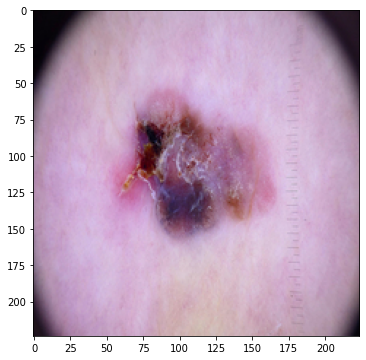

In [48]:
imshow(X_train[3])

#Bulding CNN

In [49]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

In [50]:
model = Sequential()
model.add(Conv2D(16, 7, activation='relu', input_shape=(IMG_DIMEN, IMG_DIMEN, N_COLORS)))
model.add(Conv2D(16, 7, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, 5, activation='relu'))
model.add(Conv2D(32, 5, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Training and Validation

In [51]:
import tensorflow
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'saved-model/best-model', monitor='val_loss', mode='min', 
    save_weights_only=True, save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=120,
    callbacks=[checkpoint]
)

Epoch 1/120
56/56 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.5340
Epoch 1: val_loss improved from inf to 0.68891, saving model to saved-model/best-model
56/56 [==============================] - 12s 200ms/step - loss: 0.6919 - accuracy: 0.5340 - val_loss: 0.6889 - val_accuracy: 0.5327
Epoch 2/120
56/56 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.5742
Epoch 2: val_loss did not improve from 0.68891
56/56 [==============================] - 10s 187ms/step - loss: 0.6671 - accuracy: 0.5742 - val_loss: 1.4460 - val_accuracy: 0.4673
Epoch 3/120
56/56 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.6942
Epoch 3: val_loss improved from 0.68891 to 0.54908, saving model to saved-model/best-model
56/56 [==============================] - 10s 187ms/step - loss: 0.6204 - accuracy: 0.6942 - val_loss: 0.5491 - val_accuracy: 0.7268
Epoch 4/120
56/56 [==============================] - ETA: 0s - loss: 0.5710 - accuracy: 0.7186

#Visualizin Training History

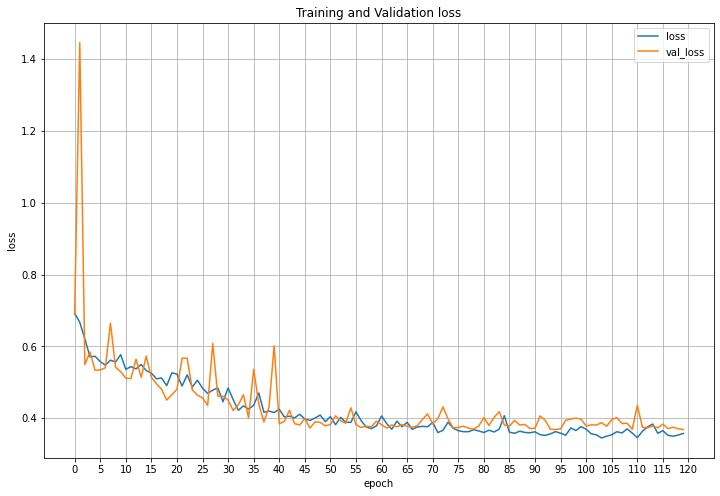

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['loss', 'val_loss'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.grid(axis='both')
plt.xticks(np.arange(0, 121, 5))
plt.show()

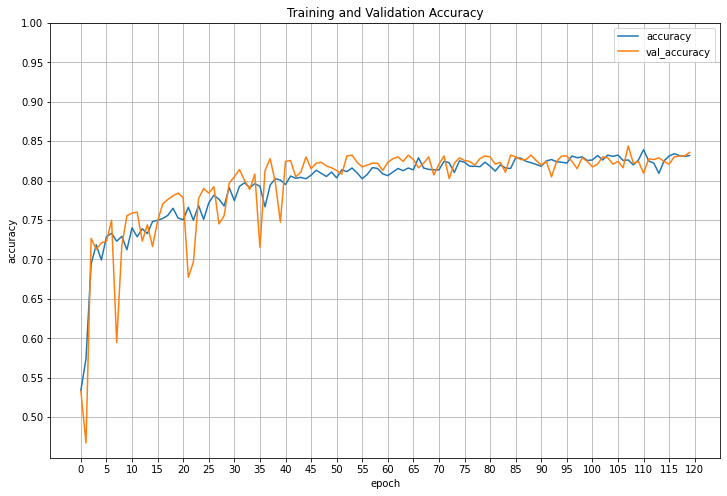

In [53]:
hist_df = pd.DataFrame(history.history)
hist_df.plot(y=['accuracy', 'val_accuracy'], figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(axis='both')
plt.xticks(np.arange(0, 121, 5))
plt.yticks(np.arange(0.5, 1.01, 0.05))
plt.show()

#Testing

In [31]:
model.load_weights('saved-model/best-model')
model.evaluate(X_test, y_test)

21/21 [==============================] - 2s 103ms/step - loss: 0.6684 - accuracy: 0.6621


[0.6683769226074219, 0.6621212363243103]